In [1]:
#### Q1 begins ####

In [2]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
    
from tqdm import tqdm
from imutils import paths
from PIL import Image
import os
import copy
import time

In [3]:
# downloads Caltech101 images from torchvision.datasets
torchvision.datasets.Caltech101(root='./data', download=True)

0it [00:00, ?it/s]

Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


0it [00:00, ?it/s]

Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


Dataset Caltech101
    Number of datapoints: 8677
    Root location: ./data/caltech101
    Target type: ['category']

In [4]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# setting the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# gets the list of all the images (their paths) present in the dataset
image_paths = sorted(list(paths.list_images('/content/data/caltech101/101_ObjectCategories')))

In [7]:
X = [] # image data (list of numpy arrays)
y = [] # labels (list of strings)

for img_path in tqdm(image_paths):
    img_class = img_path.split(os.path.sep)[-2]

    if img_class == "BACKGROUND_Google":
        continue

    # Read the image from the specified location in pil format and convert it into a numpy array
    pil_img = Image.open(img_path).convert('RGB')
    np_img = np.asarray(pil_img)

    X.append(np_img)
    y.append(img_class)
    
X = np.array(X, dtype=object)
y = np.array(y)

100%|██████████| 9144/9144 [00:20<00:00, 449.74it/s]


bonsai


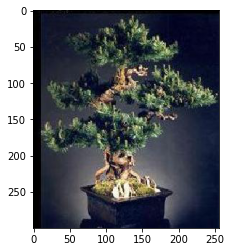

In [8]:
# printing a sample image and its label
plt.imshow(X[3000])
print(y[3000])

In [9]:
# checking the number of unique y's - i.e. number of classes present in the dataset
np.unique(y).shape

(101,)

In [10]:
# converting the y's from strings to numeric values - from 0 to 100
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(y)

In [11]:
# just seeing all the class names from the dataset
print(lb_enc.classes_)

['Faces' 'Faces_easy' 'Leopards' 'Motorbikes' 'accordion' 'airplanes'
 'anchor' 'ant' 'barrel' 'bass' 'beaver' 'binocular' 'bonsai' 'brain'
 'brontosaurus' 'buddha' 'butterfly' 'camera' 'cannon' 'car_side'
 'ceiling_fan' 'cellphone' 'chair' 'chandelier' 'cougar_body'
 'cougar_face' 'crab' 'crayfish' 'crocodile' 'crocodile_head' 'cup'
 'dalmatian' 'dollar_bill' 'dolphin' 'dragonfly' 'electric_guitar'
 'elephant' 'emu' 'euphonium' 'ewer' 'ferry' 'flamingo' 'flamingo_head'
 'garfield' 'gerenuk' 'gramophone' 'grand_piano' 'hawksbill' 'headphone'
 'hedgehog' 'helicopter' 'ibis' 'inline_skate' 'joshua_tree' 'kangaroo'
 'ketch' 'lamp' 'laptop' 'llama' 'lobster' 'lotus' 'mandolin' 'mayfly'
 'menorah' 'metronome' 'minaret' 'nautilus' 'octopus' 'okapi' 'pagoda'
 'panda' 'pigeon' 'pizza' 'platypus' 'pyramid' 'revolver' 'rhino'
 'rooster' 'saxophone' 'schooner' 'scissors' 'scorpion' 'sea_horse'
 'snoopy' 'soccer_ball' 'stapler' 'starfish' 'stegosaurus' 'stop_sign'
 'strawberry' 'sunflower' 'tick' 

In [12]:
# divide the data into train, validation, and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42) # maintains the proportion of classes in y_train and y_val according to y_trainval array

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (5552,)
Validation set size: (1389,)
Test set size: (1736,)


In [13]:
# defining the torchvision transforms for the image data for resizing the variable sized images into fixed size and normalising them

VGG_MEAN = np.array([0.485, 0.456, 0.406])
VGG_STD = np.array([0.229, 0.224, 0.225])

image_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = VGG_MEAN, std = VGG_STD)
])

In [14]:
class Caltech101_torch(Dataset):
    """ PyTorch dataset class for Caltech101 """
    
    def __init__(self, images, labels=None, transforms=None):
        self.y = labels
        self.X = images
        self.transforms = transforms
        
    # returns the number of samples in the dataset
    def __len__(self):
        return self.y.shape[0]
    
    # returns the sample at specified index
    def __getitem__(self, idx):
        np_img = self.X[idx][:] # image in numpy ndarray format
        
        # apply transforms 
        torch_img = np_img
        if self.transforms is not None:
            torch_img = self.transforms(torch_img)
        
        if self.y is not None:
            label = self.y[idx]
            return (torch_img, label)
        else:
            return torch_img 

In [15]:
# creating the torch train, validation and test datasets from the respective numpy arrays

train_dataset = Caltech101_torch(images=X_train, labels=y_train, transforms=image_transforms)
val_dataset = Caltech101_torch(images=X_val, labels=y_val, transforms=image_transforms)
test_dataset = Caltech101_torch(images=X_test, labels=y_test, transforms=image_transforms)

In [16]:
# creating the respective dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=2) 

In [17]:
# checking the dataset sizes

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 5552
Validation set size: 1389
Test set size: 1736


In [18]:
# checking the shape of an input image

print(train_dataset[0][0].shape)

torch.Size([3, 224, 224])


In [19]:
## Firstly, doing transfer learning on VGG16 pretrained on ILSVRC - training only the last layer (classification head) + finetuning last few layers with very low lr

In [20]:
# loading the pretrained vgg16 model
vgg16_model = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [21]:
# examining the model architecture
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
# freeze the params of all layers
for param in vgg16_model.parameters():
    param.requires_grad = False

In [23]:
# changing the classification head of the model from 1000 dim to 101 dim
vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=101)

In [24]:
# printing just the trainable parameters of the model
for name, param in vgg16_model.named_parameters():
    if param.requires_grad == True:
        print(name)

classifier.6.weight
classifier.6.bias


In [25]:
# move the model to GPU
vgg16_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
@torch.no_grad()
def validate(model, criterion):
    """
        Runs the model on the validation set to compute the validation loss and accuracy.

        Inputs: 
        - model: The model to use
        - criterion: The loss function

        Returns:
        - val_loss: Avg loss over the validation set
        - val_acc: Accuracy of the model on the validation set
    """
    
    running_loss = 0.0
    running_corrects = 0

    model.eval()

    for X_batch, y_batch in val_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # forward pass + compute loss
        outputs_batch = model(X_batch)
        _, preds_batch = torch.max(outputs_batch, dim=1)
        loss = criterion(outputs_batch, y_batch)

        # stats
        batch_size = X_batch.shape[0]
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds_batch == y_batch.detach())

    val_loss = running_loss / len(val_dataset)
    val_acc = running_corrects.double() / len(val_dataset)

    return val_loss, val_acc

In [27]:
def train(model, criterion, optimizer, scheduler=None, num_epochs=25, start_epoch=0):
    """
      Trains the model under specified settings.

      Inputs:
      - model: The model to train
      - criterion: The loss function to use
      - optimizer: Optimizer to use
      - scheduler: Learning rate scheduler (default: None)
      - num_epochs: Number of epochs to train the model for (default: 25)
      - start_epoch: To start training from which epoch incase the model is already trained before (default: 0)

      Returns:
      - train_losses: List of train losses recorded after each epoch.
      - train_accuracies: List of train accuracies recorded after each epoch.
      - val_losses: List of validation losses recorded after each epoch.
      - val_accuracies: List of validation accuracies recorded after each epoch.
      - model: the trained model with weights corresponding to the best validation accuracy

    """

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_accuracy = 0.0

    # per epoch stats
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f'Epoch {epoch}/{start_epoch + num_epochs - 1}')
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        model.train()

        for X_batch, y_batch in train_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass + compute loss
            outputs_batch = model(X_batch)
            _, preds_batch = torch.max(outputs_batch, dim=1)
            loss = criterion(outputs_batch, y_batch)

            # backprop + parameter update
            loss.backward()
            optimizer.step()

            # stats
            batch_size = X_batch.shape[0]
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds_batch == y_batch.detach())

        if scheduler is not None:
            scheduler.step()
        
        train_loss = running_loss / len(train_dataset)
        train_accuracy = running_corrects.double() / len(train_dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())

        val_loss, val_accuracy = validate(model, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy.item())

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation Accuracy: {best_val_accuracy:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return train_losses, train_accuracies, val_losses, val_accuracies, model 

In [28]:
# loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr = 0.005)
initial_epochs = 6

In [29]:
# training only the changed layer (the last layer)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
train_losses, train_accuracies, val_losses, val_accuracies, vgg16_model = train(vgg16_model, criterion, optimizer, exp_lr_scheduler, num_epochs=initial_epochs)

Epoch 0/5
----------
Train Loss: 1.1470, Train Accuracy: 0.7691
Validation Loss: 0.5194, Validation Accuracy: 0.8762

Epoch 1/5
----------
Train Loss: 0.2965, Train Accuracy: 0.9271
Validation Loss: 0.4995, Validation Accuracy: 0.8970

Epoch 2/5
----------
Train Loss: 0.2157, Train Accuracy: 0.9416
Validation Loss: 0.4628, Validation Accuracy: 0.9093

Epoch 3/5
----------
Train Loss: 0.1187, Train Accuracy: 0.9649
Validation Loss: 0.4376, Validation Accuracy: 0.9107

Epoch 4/5
----------
Train Loss: 0.0901, Train Accuracy: 0.9714
Validation Loss: 0.4086, Validation Accuracy: 0.9107

Epoch 5/5
----------
Train Loss: 0.0705, Train Accuracy: 0.9780
Validation Loss: 0.4013, Validation Accuracy: 0.9150

Training complete in 3m 37s
Best validation Accuracy: 0.9150


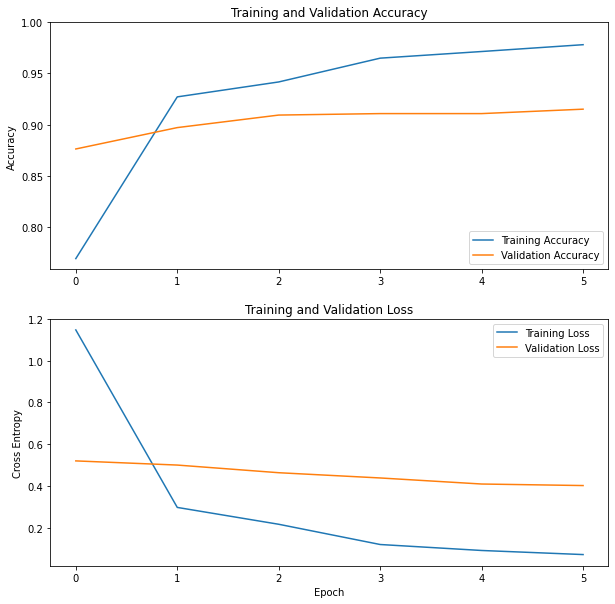

In [30]:
# Learning curves
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [31]:
# unfreeze last few layers of the model and finetune at a very low learning rate to slightly improve performance

In [32]:
# check the model layers
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
# unfreeze all the FC layers
for param in vgg16_model.classifier.parameters():
    param.requires_grad = True

In [34]:
# unfreeze the last conv layer - it is at position 28 in vgg19_model.features
for param in vgg16_model.features[28].parameters():
    param.requires_grad = True

In [35]:
# printing just the trainable parameters of the model
for name, param in vgg16_model.named_parameters():
    if param.requires_grad == True:
        print(name)

features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [36]:
# finetuning - training the unfreezed layers at a very low learning rate
finetune_epochs = 4
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr = 0.00005)
train_losses_ft, train_accuracies_ft, val_losses_ft, val_accuracies_ft, vgg16_model = train(vgg16_model, criterion, optimizer, num_epochs=finetune_epochs, start_epoch=initial_epochs)

Epoch 6/9
----------
Train Loss: 0.0719, Train Accuracy: 0.9796
Validation Loss: 0.3737, Validation Accuracy: 0.9266

Epoch 7/9
----------
Train Loss: 0.0473, Train Accuracy: 0.9865
Validation Loss: 0.3777, Validation Accuracy: 0.9222

Epoch 8/9
----------
Train Loss: 0.0258, Train Accuracy: 0.9923
Validation Loss: 0.3688, Validation Accuracy: 0.9230

Epoch 9/9
----------
Train Loss: 0.0255, Train Accuracy: 0.9924
Validation Loss: 0.4149, Validation Accuracy: 0.9086

Training complete in 2m 40s
Best validation Accuracy: 0.9266


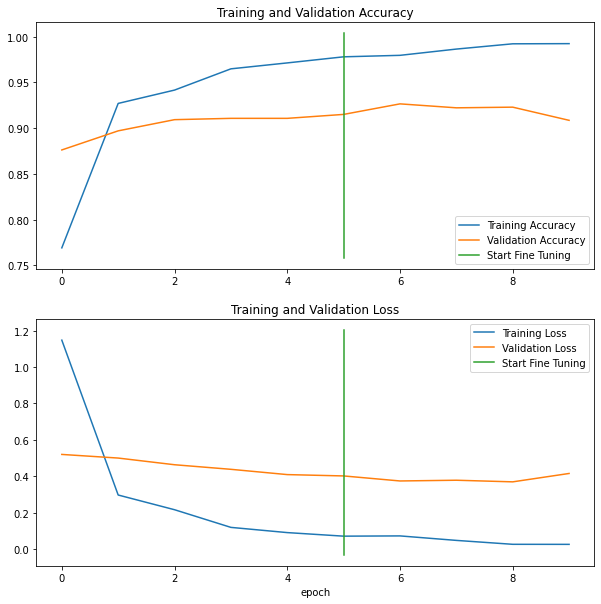

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies + train_accuracies_ft, label='Training Accuracy')
plt.plot(val_accuracies + val_accuracies_ft, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses+train_losses_ft, label='Training Loss')
plt.plot(val_losses+val_losses_ft, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
# From the graphs above and the training logs we can see slight improvement in the best validation accuracy (from 91.79 to 92.87 %) after finetuning

In [39]:
## Q1 part2 -> same model as above but with random initialization

In [40]:
# loading the vgg16 model without pretrained weights (i.e. randomly initialised weights)
vgg16_model_rnd = models.vgg16(weights=None)

In [41]:
# changing the classification head of the model from 1000 dim to 101 dim
vgg16_model_rnd.classifier[6] = nn.Linear(in_features=4096, out_features=101)

In [42]:
# printing just the trainable parameters of the model - all the layers are trainable as instructed in part2 of Q1
for name, param in vgg16_model_rnd.named_parameters():
    if param.requires_grad == True:
        print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [43]:
# move the model to GPU
vgg16_model_rnd.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
# loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_model_rnd.parameters(), lr = 0.005)

In [45]:
# training the randomly initialised model under similar settings

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
train_losses_rnd, train_accuracies_rnd, val_losses_rnd, val_accuracies_rnd, vgg16_model_rnd = train(vgg16_model_rnd, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
Train Loss: 22715212.7960, Train Accuracy: 0.0254
Validation Loss: 4.5751, Validation Accuracy: 0.0886

Epoch 1/4
----------
Train Loss: 4.8435, Train Accuracy: 0.0911
Validation Loss: 4.4965, Validation Accuracy: 0.0958

Epoch 2/4
----------
Train Loss: 6.7834, Train Accuracy: 0.0951
Validation Loss: 4.4372, Validation Accuracy: 0.0958

Epoch 3/4
----------
Train Loss: 4.5200, Train Accuracy: 0.0955
Validation Loss: 4.3927, Validation Accuracy: 0.0958

Epoch 4/4
----------
Train Loss: 4.4489, Train Accuracy: 0.0958
Validation Loss: 4.3600, Validation Accuracy: 0.0958

Training complete in 6m 43s
Best validation Accuracy: 0.0958


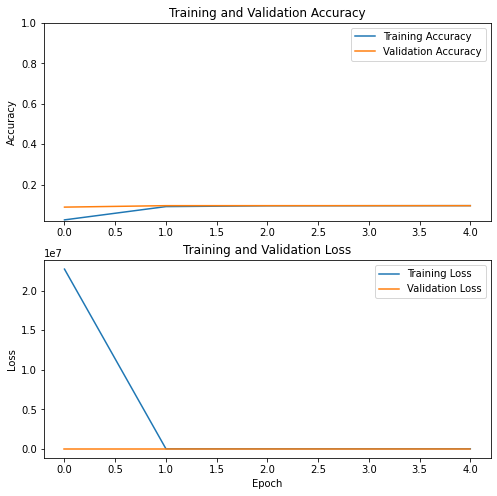

In [46]:
# Learning curves
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies_rnd, label='Training Accuracy')
plt.plot(val_accuracies_rnd, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses_rnd, label='Training Loss')
plt.plot(val_losses_rnd, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [47]:
# reporting the performance of both the models (one using transfer learning and other without it) on the test set

In [48]:
def compute_test_acc(model):
    """
      Computes the accuracy of the model on the test set.

      Inputs:
      - model: the model to evaluate
      
      Returns:
      - test_acc: a fraction representing the test set accuracy
    """
    running_corrects = 0
    model.eval()

    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # forward pass
        outputs_batch = model(X_batch)
        _, preds_batch = torch.max(outputs_batch, dim=1)

        # stats
        running_corrects += torch.sum(preds_batch == y_batch.detach())

    test_acc = running_corrects.double() / len(test_dataset)

    return test_acc

In [49]:
test_acc_transferLearning = compute_test_acc(vgg16_model)
test_acc_rnd = compute_test_acc(vgg16_model_rnd)

print(f"Test set accuracy of the model trained using transfer learning = {(test_acc_transferLearning * 100):.2f}%")
print(f"Test set accuracy of the model trained using random weight initialization = {(test_acc_rnd * 100):.2f}%")

Test set accuracy of the model trained using transfer learning = 91.99%
Test set accuracy of the model trained using random weight initialization = 7.83%


In [50]:
# Thus we see how worse the model with randomly initialised weights perform

In [51]:
######### end of Q1 #############

In [52]:
#### Q2 begins ####

In [53]:
def create_dataset(num_samples, min_seq_len=2, max_seq_len=10):
    """
        Creates a dataset for the task of "the adding problem".

        Inputs:
        - num_samples: Number of input sequences in the dataset
        - min_seq_len: Lower bound for the sequence length
        - max_seq_len: Upper bound for the sequence length

        Returns:
        - X: python list where each element is an input sequence (a torch tensor of shape (seq_len, 2))
        - Y: torch tensor of shape (num_samples, 1) for labels - sum of seq elems whose second dimensions are marked by 1

    """
    
    X = []
    Y = torch.zeros(num_samples, 1)

    for i in tqdm(range(num_samples)):
        seq_len = torch.randint(min_seq_len, max_seq_len+1, (1, )).item()
        X_num = torch.FloatTensor(seq_len, 1).uniform_(0.0, 1.0) # generates numbers uniformly at random between 0 and 1 for the sequence
        X_mask = torch.zeros(seq_len, 1)

        one_positions = np.random.choice(seq_len, size=2, replace=False) # randomly choose two positions of the sequence
        X_mask[one_positions, :] = 1
        Y[i, 0] = torch.sum(X_num[one_positions]) # defining the label (i.e. the target sum)

        Xi = torch.cat((X_num, X_mask), dim=-1) # shape is (seq_len, 2)
        X.append(Xi)

    return X, Y

In [54]:
# creating a big dataset of size 10000 and then splitting it into train, val and test sets

In [55]:
X_full, y_full = create_dataset(10000)

100%|██████████| 10000/10000 [00:01<00:00, 9291.28it/s]


In [56]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
len(X_trainval), y_trainval.shape, len(X_test), y_test.shape

(8000, torch.Size([8000, 1]), 2000, torch.Size([2000, 1]))

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)
len(X_train), y_train.shape, len(X_val), y_val.shape

(6400, torch.Size([6400, 1]), 1600, torch.Size([1600, 1]))

In [58]:
class Baseline(nn.Module):
    """ Baseline model that always predicts a sum of 1 as specified in the question """
    
    def __init__(self):
        super(Baseline, self).__init__()

    def forward(self, input):
        batch_size = input.shape[0]
        output = torch.ones(batch_size, 1, dtype=torch.float32)
        return output

In [59]:
class Elman(nn.Module):
    """ Elman network - a very basic version of the RNN """

    def __init__(self, dim_input, dim_hidden, dim_output):
        super(Elman, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_hidden)
        self.fc_h2h = nn.Linear(dim_hidden, dim_hidden, bias = False)
        self.fc_h2y = nn.Linear(dim_hidden, dim_output)

    def forward(self, input):
        batch_size = input.shape[0]
        seq_len = input.shape[1]
        dim_hidden = self.fc_h2h.in_features

        h = input.new_zeros(batch_size, dim_hidden) # initialize the hidden state with zeros
        
        for t in range(seq_len):
            h = torch.tanh(self.fc_x2h(input[:, t]) + self.fc_h2h(h)) # updating the hidden state as per the Elman equation

        return self.fc_h2y(h)

In [60]:
class LSTM(nn.Module):
    """ Pytorch class for the LSTM network """

    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.fc_x2h = nn.Linear(dim_input, 4 * dim_hidden)
        self.fc_h2h = nn.Linear(dim_hidden, 4 * dim_hidden, bias = False)
        self.fc_h2y = nn.Linear(dim_hidden, dim_output)

    def forward(self, input):
        batch_size = input.shape[0]
        seq_len = input.shape[1]
        dim_hidden = self.fc_h2h.in_features
        
        # initialize the hidden state and cell state with zeros
        h = input.new_zeros(batch_size, dim_hidden)
        c = input.new_zeros(batch_size, dim_hidden)

        for t in range(seq_len):
            tmp = self.fc_x2h(input[:, t]) + self.fc_h2h(h) # shape of tmp is (batch_size, 4 * dim_hidden)

            forget_gate = torch.sigmoid(tmp[:, 0 : dim_hidden]) # denoted by f_t in the slides dl4cv-10, pg 42
            input_gate = torch.sigmoid(tmp[:, dim_hidden : 2 * dim_hidden]) # denoted by i_t in the slides dl4cv-10, pg 42
            output_gate = torch.sigmoid(tmp[:, 2 * dim_hidden : 3 * dim_hidden]) # denoted by o_t in the slides dl4cv-10, pg 42

            c_tilda = torch.tanh(tmp[:, 3 * dim_hidden : 4 * dim_hidden]) # denoted by g_t in the slides dl4cv-10, pg 42
            c = forget_gate * c + input_gate * c_tilda # these are elementwise muls (hadamard products)
            h = output_gate * torch.tanh(c)

        return self.fc_h2y(h)

In [61]:
class GRU(nn.Module):
    """ Pytorch class for the GRU network """

    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.fc_x2h_gate = nn.Linear(dim_input, 2 * dim_hidden)
        self.fc_h2h_gate = nn.Linear(dim_hidden, 2 * dim_hidden, bias = False)

        self.fc_x2h = nn.Linear(dim_input, dim_hidden)
        self.fc_h2h = nn.Linear(dim_hidden, dim_hidden, bias=False)

        self.fc_h2y = nn.Linear(dim_hidden, dim_output)

    def forward(self, input):
        batch_size = input.shape[0]
        seq_len = input.shape[1]
        dim_hidden = self.fc_h2h.in_features

        # initialize the hidden state with zeros
        h = input.new_zeros(batch_size, dim_hidden)

        for t in range(seq_len):
            tmp = self.fc_x2h_gate(input[:, t]) + self.fc_h2h_gate(h)

            reset_gate = torch.sigmoid(tmp[:, 0 : dim_hidden]) # denoted by r_t in the slides dl4cv-10, pg 49
            forget_gate = torch.sigmoid(tmp[:, dim_hidden : 2 * dim_hidden]) # denoted by z_t in the slides dl4cv-10, pg 49

            h_tilda = torch.tanh(self.fc_x2h(input[:, t]) + self.fc_h2h(reset_gate * h)) # denoted by h_t(bar) in the slides dl4cv-10, pg 49
            h = forget_gate * h + (1 - forget_gate) * h_tilda

        return self.fc_h2y(h)

In [62]:
x_dim = 2 
h_dim = 8
y_dim = 1

# Initialising the different models and moving them to GPU
baseline_model = Baseline().to(device)
elman_model = Elman(dim_input=x_dim, dim_hidden=h_dim, dim_output=y_dim).to(device)
lstm_model = LSTM(dim_input=x_dim, dim_hidden=h_dim, dim_output=y_dim).to(device)
gru_model = GRU(dim_input=x_dim, dim_hidden=h_dim, dim_output=y_dim).to(device)

In [63]:
criterion = nn.MSELoss()
num_epochs = 3

# training all the networks under similar settings
optimizer_elman = torch.optim.Adam(elman_model.parameters(), lr = 0.003)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr = 0.003)
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr = 0.003)

In [64]:
@torch.no_grad()
def compute_avg_validation_loss(model, criterion):
    """
        Computes the avg loss over the validation set.

        Inputs:
        - model: the model to use
        - criterion: the loss function to use

        Returns:
        - avg_val_loss: Average value of loss per sample in the validation set.
    """

    model.eval()
    
    num_samples = len(X_val)
    total_val_loss = 0.0

    for i in range(num_samples):
        Xi = copy.deepcopy(X_val[i])
        Xi = Xi.unsqueeze_(0)
        Xi = Xi.to(device)

        yi = copy.deepcopy(y_val[i])
        yi = yi.unsqueeze_(0)
        yi = yi.to(device)

        # forward pass + loss computation
        output = model(Xi)
        loss = criterion(output, yi)
        total_val_loss += loss

    avg_val_loss = total_val_loss / num_samples
    return avg_val_loss

In [65]:
def train(model, optimizer, criterion):
    """
        Performs the model training over the training dataset using SGD and returns the model with minimum val loss. 

        Inputs:
        - model: The model to train
        - optimizer: The optimizer to use for model training
        - criterion: the loss function to use

        Returns:
        - train_losses: List of avg train losses after periodic number of iterations of SGD
        - val_losses: List of avg val losses after periodic number of iterations of SGD
        - model: trained model

    """    
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = np.inf

    train_losses = []
    val_losses = []

    total_train_loss = 0.0
    num_steps = 0

    model.train()

    for epoch in range(num_epochs):
        num_samples = len(X_train)

        for i in range(num_samples):
            if num_steps != 0 and num_steps % 500 == 0:
                avg_train_loss = total_train_loss / num_steps
                avg_val_loss = compute_avg_validation_loss(model, criterion)

                train_losses.append(avg_train_loss.item())
                val_losses.append(avg_val_loss.item())

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

                print(f"Avg training loss after {num_steps} steps of SGD = {avg_train_loss:.6f}")
                print(f"Avg validation loss after {num_steps} steps of SGD = {avg_val_loss:.6f}")
                print()

            Xi = copy.deepcopy(X_train[i])
            Xi = Xi.unsqueeze_(0)
            Xi = Xi.to(device)

            yi = copy.deepcopy(y_train[i])
            yi = yi.unsqueeze_(0)
            yi = yi.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass + loss computation
            output = model(Xi)
            loss = criterion(output, yi)
            total_train_loss += loss

            # backward pass + parameter update
            loss.backward()
            optimizer.step()
            num_steps += 1

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_val_loss:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return train_losses, val_losses, model

In [66]:
# Training the Elman network
train_losses_elman, val_losses_elman, elman_model = train(elman_model, optimizer_elman, criterion)

Avg training loss after 500 steps of SGD = 0.236817
Avg validation loss after 500 steps of SGD = 0.153588

Avg training loss after 1000 steps of SGD = 0.202168
Avg validation loss after 1000 steps of SGD = 0.143455

Avg training loss after 1500 steps of SGD = 0.176599
Avg validation loss after 1500 steps of SGD = 0.110868

Avg training loss after 2000 steps of SGD = 0.160603
Avg validation loss after 2000 steps of SGD = 0.101735

Avg training loss after 2500 steps of SGD = 0.151852
Avg validation loss after 2500 steps of SGD = 0.097955

Avg training loss after 3000 steps of SGD = 0.146670
Avg validation loss after 3000 steps of SGD = 0.116370

Avg training loss after 3500 steps of SGD = 0.139731
Avg validation loss after 3500 steps of SGD = 0.091646

Avg training loss after 4000 steps of SGD = 0.132680
Avg validation loss after 4000 steps of SGD = 0.067708

Avg training loss after 4500 steps of SGD = 0.124989
Avg validation loss after 4500 steps of SGD = 0.080662

Avg training loss aft

In [67]:
# Training the LSTM
train_losses_lstm, val_losses_lstm, lstm_model = train(lstm_model, optimizer_lstm, criterion)

Avg training loss after 500 steps of SGD = 0.278123
Avg validation loss after 500 steps of SGD = 0.144666

Avg training loss after 1000 steps of SGD = 0.215305
Avg validation loss after 1000 steps of SGD = 0.122729

Avg training loss after 1500 steps of SGD = 0.176902
Avg validation loss after 1500 steps of SGD = 0.078397

Avg training loss after 2000 steps of SGD = 0.147703
Avg validation loss after 2000 steps of SGD = 0.027565

Avg training loss after 2500 steps of SGD = 0.122255
Avg validation loss after 2500 steps of SGD = 0.010078

Avg training loss after 3000 steps of SGD = 0.103089
Avg validation loss after 3000 steps of SGD = 0.005167

Avg training loss after 3500 steps of SGD = 0.089177
Avg validation loss after 3500 steps of SGD = 0.004106

Avg training loss after 4000 steps of SGD = 0.078685
Avg validation loss after 4000 steps of SGD = 0.004678

Avg training loss after 4500 steps of SGD = 0.070448
Avg validation loss after 4500 steps of SGD = 0.003250

Avg training loss aft

In [68]:
# Training the GRU
train_losses_gru, val_losses_gru, gru_model = train(gru_model, optimizer_gru, criterion)

Avg training loss after 500 steps of SGD = 0.193210
Avg validation loss after 500 steps of SGD = 0.137859

Avg training loss after 1000 steps of SGD = 0.145819
Avg validation loss after 1000 steps of SGD = 0.028011

Avg training loss after 1500 steps of SGD = 0.102616
Avg validation loss after 1500 steps of SGD = 0.008732

Avg training loss after 2000 steps of SGD = 0.079019
Avg validation loss after 2000 steps of SGD = 0.006287

Avg training loss after 2500 steps of SGD = 0.064232
Avg validation loss after 2500 steps of SGD = 0.003355

Avg training loss after 3000 steps of SGD = 0.054016
Avg validation loss after 3000 steps of SGD = 0.002613

Avg training loss after 3500 steps of SGD = 0.046637
Avg validation loss after 3500 steps of SGD = 0.001581

Avg training loss after 4000 steps of SGD = 0.041055
Avg validation loss after 4000 steps of SGD = 0.001970

Avg training loss after 4500 steps of SGD = 0.036659
Avg validation loss after 4500 steps of SGD = 0.001199

Avg training loss aft

In [69]:
def plot_learning_curves(train_losses, val_losses, model_name):
    iters = range(500, 19500, 500)
    plt.plot(iters, train_losses, 'g', label='Training loss')
    plt.plot(iters, val_losses, 'b', label='Validation loss')
    plt.title(f'Training and Validation loss for {model_name}')
    plt.xlabel('Number of SGD iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

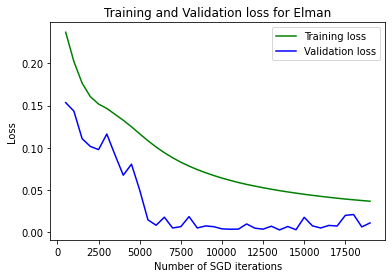

In [70]:
plot_learning_curves(train_losses_elman, val_losses_elman, 'Elman')

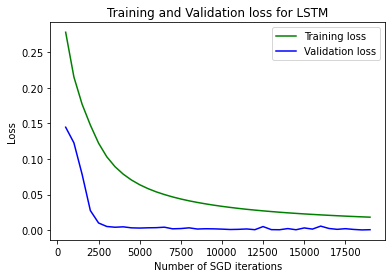

In [71]:
plot_learning_curves(train_losses_lstm, val_losses_lstm, 'LSTM')

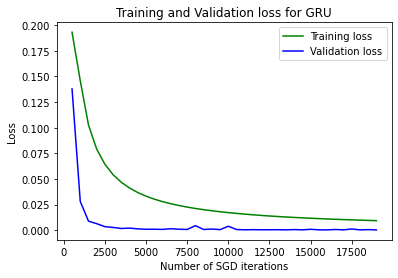

In [72]:
plot_learning_curves(train_losses_gru, val_losses_gru, 'GRU')

In [73]:
# using two popular metrics - RMSE (Mean Squared Error), MAE (Mean Absolute Error) to compare the test performance of the above regression models

In [74]:
@torch.no_grad()
def compute_test_metrics(model):
    """
        Computes performance metrics for the given regression model.

        Inputs:
        - model: the regression model provided

        Returns:
        - rmse_error: Root Mean Squared Error measured between predictions and targets
        - mae_error: Mean Absolute Error measured between predictions and targets
    """

    model.eval()
    
    num_samples = len(X_test)
    preds = torch.zeros(num_samples, 1)

    for i in range(num_samples):
        Xi = copy.deepcopy(X_test[i])
        Xi = Xi.unsqueeze_(0)
        Xi = Xi.to(device)

        output = model(Xi)
        preds[i] = output[0]

    rmse_error = mean_squared_error(y_test, preds, squared=False)
    mae_error = mean_absolute_error(y_test, preds)

    return rmse_error, mae_error

In [75]:
# compute rmse and mae results on the test set using the 4 regression models

baseline_rmse, baseline_mae = compute_test_metrics(baseline_model)
elman_rmse, elman_mae = compute_test_metrics(elman_model)
lstm_rmse, lstm_mae = compute_test_metrics(lstm_model)
gru_rmse, gru_mae = compute_test_metrics(gru_model)

In [76]:
print(baseline_rmse, elman_rmse, lstm_rmse, gru_rmse)
print(baseline_mae, elman_mae, lstm_mae, gru_mae)

# Lesser the RMSE, MAE, better the model

# Performance RMSE: GRU ~ LSTM > ELMAN >> BASELINE
# Performance MAE: GRU ~ LSTM > ELMAN >> BASELINE

# As per the metrics, GRU is very slightly better than LSTM on this task
# Both GRU and LSTM are fairly better than the Elman
# All the GRU, LSTM, Elman are much much better than the baseline

0.41495657 0.057831366 0.019503199 0.014327526
0.33996385 0.04411822 0.0149566345 0.0116455555


In [77]:
######### end of Q2 #############